In [1]:
import datetime
import logging

import matplotlib.pyplot as plt
from tqdm import tqdm

from ocean_navigation_simulator.controllers.hj_planners.HJReach2DPlanner import (
    HJReach2DPlanner,
)
from ocean_navigation_simulator.environment.ArenaFactory import ArenaFactory
from ocean_navigation_simulator.environment.NavigationProblem import (
    NavigationProblem,
)
from ocean_navigation_simulator.environment.Platform import PlatformState
from ocean_navigation_simulator.environment.PlatformState import SpatialPoint
from ocean_navigation_simulator.utils import units
from ocean_navigation_simulator.utils.misc import set_arena_loggers

In [2]:

# Initialize the Arena (holds all data sources and the platform, everything except controller)
arena = ArenaFactory.create(
    # BN: This corresponds to a YAML file, which contains a lot of metadata, including platform
    # information like drag factor and max speed
    # You can find it in OceanPlatformControl/config/arena
    # TODO: Please test this out
    scenario_name="gulf_of_mexico_HYCOM_hindcast_BN",
    # Note: uncomment this to download the hindcast data if not already locally available
    # t_interval=[
    #     datetime.datetime(2021, 11, 23, 12, 0, tzinfo=datetime.timezone.utc),
    #     datetime.datetime(2021, 11, 30, 12, 0, tzinfo=datetime.timezone.utc)]
)
# we can also download the respective files directly to a temp folder, then t_interval needs to be set
# % Specify Navigation Problem
# BN: This is the starting location for the platform, which is the water vessel
x_0 = PlatformState(
    lon=units.Distance(deg=-82.5),
    lat=units.Distance(deg=23.7),
    date_time=datetime.datetime(2021, 11, 24, 12, 0, tzinfo=datetime.timezone.utc),
)
x_T = SpatialPoint(lon=units.Distance(deg=-80.3), lat=units.Distance(deg=24.6))

# BN: This defines the navgiation "problem". Note that NavigationProblem inherits Problem, so
# when you're looking for the class defintiion, there are functions defined in both
# I haven't quite figured out everything in this class yet....
problem = NavigationProblem(
    start_state=x_0,
    end_region=x_T,
    target_radius=0.1,
)


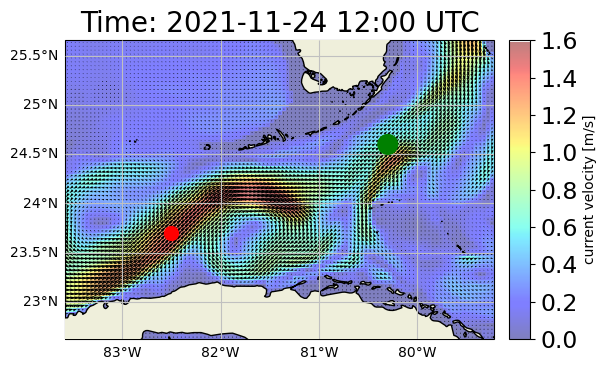

In [3]:
# BN: This plots the problem

t_interval, lat_bnds, lon_bnds = arena.ocean_field.hindcast_data_source.convert_to_x_y_time_bounds(
    x_0=x_0.to_spatio_temporal_point(), x_T=x_T, deg_around_x0_xT_box=1, temp_horizon_in_s=3600
)

ax = arena.ocean_field.hindcast_data_source.plot_data_at_time_over_area(
    time=x_0.date_time, x_interval=lon_bnds, y_interval=lat_bnds, return_ax=True
)
problem.plot(ax=ax)
plt.show()

In [4]:
specific_settings = {
    "replan_on_new_fmrc": True,
    "replan_every_X_seconds": False,
    "direction": "multi-time-reach-back",
    "n_time_vector": 200,
    "closed_loop": True,  # to run closed-loop or open-loop
    # Note that this is the number of time-intervals, the vector is +1 longer because of init_time
    "deg_around_xt_xT_box": 1.0,  # area over which to run HJ_reachability
    "accuracy": "high",
    "artificial_dissipation_scheme": "local_local",
    "T_goal_in_seconds": 3600 * 24 * 5,
    "use_geographic_coordinate_system": True,
    "progress_bar": True,
    "initial_set_radii": [
        0.1,
        0.1,
    ],  # this is in deg lat, lon. Note: for Backwards-Reachability this should be bigger.
    # Note: grid_res should always be bigger than initial_set_radii, otherwise reachability behaves weirdly.
    "grid_res": 0.02,  # Note: this is in deg lat, lon (HYCOM Global is 0.083 and Mexico 0.04)
    "d_max": 0.0,
    # 'EVM_threshold': 0.3 # in m/s error when floating in forecasted vs sensed currents
    # 'fwd_back_buffer_in_seconds': 0.5,  # this is the time added to the earliest_to_reach as buffer for forward-backward
    "platform_dict": arena.platform.platform_dict,
}

#BN: This is the "planner", which as far as I can tell, tells you what the next motion/action
# the platform/simulation should take next (e.g. direction and propusion of the water craft)
planner = HJReach2DPlanner(problem=problem, specific_settings=specific_settings)

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [5]:
# BN: This would be good to look into
# It appears to tell you where is reachable and in how much time
# but I can't seem to figure out how to extract the time to reach the
# end point from here, so I rely on the next part to figure it out

# % Run reachability planner
observation = arena.reset(platform_state=x_0)
action = planner.get_action(observation=observation)


100%|#################################|  1.0000/1.0 [08:18<00:00, 498.63s/sim_s]


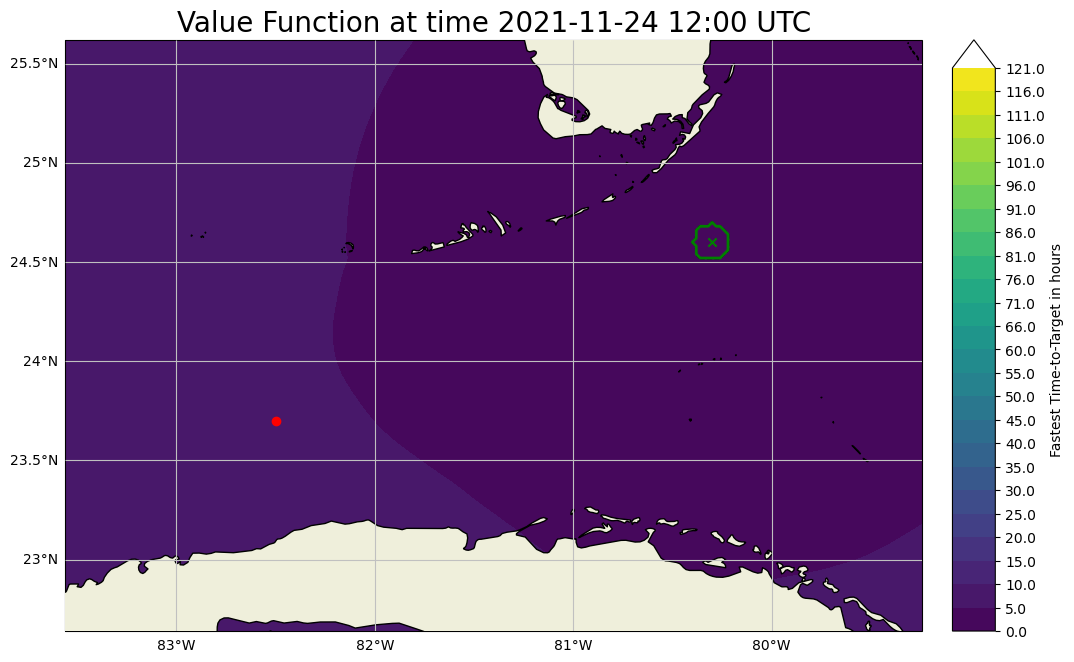

In [6]:
# %% Various plotting of the reachability computations
planner.plot_reachability_snapshot(
    rel_time_in_seconds=0,
    granularity_in_h=5,
    alpha_color=1,
    time_to_reach=True,
    fig_size_inches=(12, 12),
    plot_in_h=True,
)

In [7]:
# BN: What I think this does is, it iterates through all of the actions dictated by the planner
# i.e., given that I'm at point X, what direction and propulstion should I go in?
# It iterates over a period defined by 3600 * 24 * 5 / 600, which is 5 days. I believe the reason
# it divides by 600 is because it issues new actions every 10 minutes (600 seconds). I believe you 
# define this level of granularity based on the config YAML file. 

#BN: I added this in; it's a flag saying whether the platform has arrived in the target area yet
unsolved = 1

for i in tqdm(range(int(3600 * 24 * 5 / 600))):  # 5 days
    # BN: "What action should I take?"
    action = planner.get_action(observation=observation)
    #BN: "Now perform that action and update the new observation"
    observation = arena.step(action)
    
    #BN: I added this statement in; it appears that the problem keeps track of whether
    # it has been solved yet; if it has, then return back how long it took to get there. 
#     if i % 10 == 0:
#         print(i, problem.haversine(observation.platform_state).rad_to_km)
    if (problem.is_done(observation.platform_state) ) and (unsolved):
        print(i)
        print(datetime.timedelta(seconds=i*600))
        unsolved = 0
        break
    # print (problem.distance(observation.platform_state).meters)
    # print (problem.is_done(observation.platform_state))
        

  5%|██                                        | 36/720 [00:01<00:34, 20.08it/s]

36
6:00:00


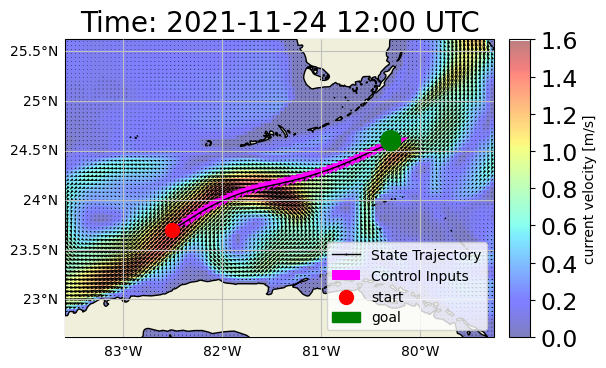

In [8]:
#%% Plot the arena trajectory on the map
arena.plot_all_on_map(problem=problem)
#%% Animate the trajectory
arena.animate_trajectory(problem=problem, temporal_resolution=7200)